# Задача

Сформировать сетку полигонов вокруг точек из таблицы `facility`

## Подключаем библиотеки

* Единоразово устанавливаем h3pandas

In [1]:
# %pip install h3pandas

In [2]:
import h3pandas
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

## Определяем функцию для вывода данных

* Функция вывода центрального региона набора геоданных

In [3]:
def get_center(df, qt = 0.1):
    return df.loc[
        (df['lng'] > df['lng'].quantile(qt)) &
        (df['lng'] < df['lng'].quantile(1-qt)) &
        (df['lat'] > df['lat'].quantile(qt)) &
        (df['lat'] < df['lat'].quantile(1-qt))]

## Грузим данные

In [4]:
facility = pd.read_csv('data/facility.csv')

In [5]:
print(facility.shape)
facility.head(3)

(5041, 10)


,facility_id,type2,name,coordinats,address,category,x,y,geometry,number_of_inhabitants
0,5137,Дом,Многоквартирный дом,"[64.455331, 40.62206]",NaN,NaN,64.455331,40.622060,0101000000B876A224241D50402B137EA99F4F4440,33.0
1,794,Дом,Многоквартирный дом,"[64.455491, 40.622967]",NaN,NaN,64.455491,40.622967,0101000000D427B9C3261D50405EBEF561BD4F4440,32.6
2,795,Дом,Многоквартирный дом,"[64.455494, 40.623901]",NaN,NaN,64.455494,40.623901,01010000008D614ED0261D50408978EBFCDB4F4440,15.4


## Обрабатываем данные

* Проверяем что нет нулей в object_id
* Привеодим object_id к целочисленному значению
* Переименовываем столбцы для h3pandas
* Удаляем лишние столбцы

In [6]:
nulls = len(facility[facility['facility_id'].isnull()])
assert nulls == 0

In [7]:
facility = facility.astype({'facility_id': 'int32'})
facility.head(3)

,facility_id,type2,name,coordinats,address,category,x,y,geometry,number_of_inhabitants
0,5137,Дом,Многоквартирный дом,"[64.455331, 40.62206]",NaN,NaN,64.455331,40.622060,0101000000B876A224241D50402B137EA99F4F4440,33.0
1,794,Дом,Многоквартирный дом,"[64.455491, 40.622967]",NaN,NaN,64.455491,40.622967,0101000000D427B9C3261D50405EBEF561BD4F4440,32.6
2,795,Дом,Многоквартирный дом,"[64.455494, 40.623901]",NaN,NaN,64.455494,40.623901,01010000008D614ED0261D50408978EBFCDB4F4440,15.4


In [8]:
facility = facility.rename({'y': 'lng', 'x': 'lat'}, axis=1)
facility.head(3)

,facility_id,type2,name,coordinats,address,category,lat,lng,geometry,number_of_inhabitants
0,5137,Дом,Многоквартирный дом,"[64.455331, 40.62206]",NaN,NaN,64.455331,40.622060,0101000000B876A224241D50402B137EA99F4F4440,33.0
1,794,Дом,Многоквартирный дом,"[64.455491, 40.622967]",NaN,NaN,64.455491,40.622967,0101000000D427B9C3261D50405EBEF561BD4F4440,32.6
2,795,Дом,Многоквартирный дом,"[64.455494, 40.623901]",NaN,NaN,64.455494,40.623901,01010000008D614ED0261D50408978EBFCDB4F4440,15.4


In [9]:
facility = facility.drop(columns=['coordinats', 'geometry'])
facility.head(3)

,facility_id,type2,name,address,category,lat,lng,number_of_inhabitants
0,5137,Дом,Многоквартирный дом,NaN,NaN,64.455331,40.622060,33.0
1,794,Дом,Многоквартирный дом,NaN,NaN,64.455491,40.622967,32.6
2,795,Дом,Многоквартирный дом,NaN,NaN,64.455494,40.623901,15.4


## Проверяем, что у нас в центре города

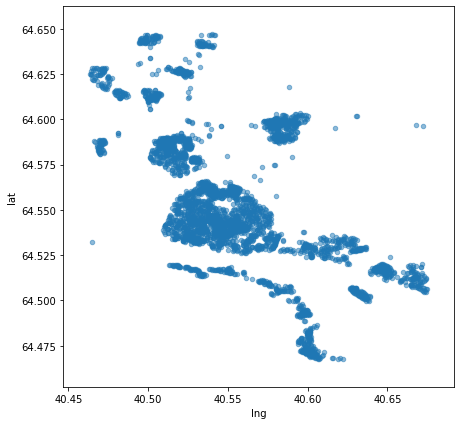

In [10]:
get_center(facility, 0.08).plot.scatter(x='lng', y='lat', figsize=(7,7), alpha=0.5)

## Приводим данные к формату h3pandas

In [11]:
facility3 = facility.h3.geo_to_h3(9)
facility3.head()

,facility_id,type2,name,address,category,lat,lng,number_of_inhabitants
h3_09,,,,,,,,
8911503346fffff,5137,Дом,Многоквартирный дом,NaN,NaN,64.455331,40.622060,33.0
8911503346fffff,794,Дом,Многоквартирный дом,NaN,NaN,64.455491,40.622967,32.6
891150330d3ffff,795,Дом,Многоквартирный дом,NaN,NaN,64.455494,40.623901,15.4
891150330d7ffff,796,Дом,Многоквартирный дом,NaN,NaN,64.455545,40.624683,22.5
891150330d3ffff,797,Дом,Многоквартирный дом,NaN,NaN,64.455172,40.625401,23.5


In [12]:
geofacility3 = facility3.h3.h3_to_geo_boundary()
geofacility3.head(3)

,facility_id,type2,name,address,category,lat,lng,number_of_inhabitants,geometry
h3_09,,,,,,,,,
8911503346fffff,5137,Дом,Многоквартирный дом,NaN,NaN,64.455331,40.622060,33.0,"POLYGON ((40.61759 64.45587, 40.62060 64.45488..."
8911503346fffff,794,Дом,Многоквартирный дом,NaN,NaN,64.455491,40.622967,32.6,"POLYGON ((40.61759 64.45587, 40.62060 64.45488..."
891150330d3ffff,795,Дом,Многоквартирный дом,NaN,NaN,64.455494,40.623901,15.4,"POLYGON ((40.61995 64.45313, 40.62296 64.45214..."


## Рисуем наши полигоны в центер города

In [13]:
# Раскомментировать в случае надобности
#geofacility3.explore(width='30%', height='60%')

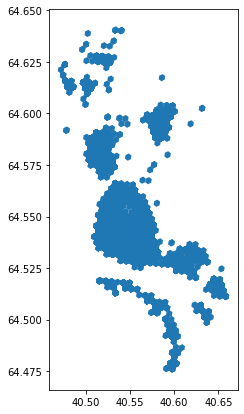

In [14]:
get_center(geofacility3).plot(figsize=(7,7))

## Строим набор данных для точек

In [15]:
facility.head(3)

,facility_id,type2,name,address,category,lat,lng,number_of_inhabitants
0,5137,Дом,Многоквартирный дом,NaN,NaN,64.455331,40.622060,33.0
1,794,Дом,Многоквартирный дом,NaN,NaN,64.455491,40.622967,32.6
2,795,Дом,Многоквартирный дом,NaN,NaN,64.455494,40.623901,15.4


In [16]:
geometry = [Point(xy) for xy in zip(facility.lng, facility.lat)]
geofacility = gpd.GeoDataFrame(facility, crs=geofacility3.crs, geometry=geometry)
geofacility.head(3)

,facility_id,type2,name,address,category,lat,lng,number_of_inhabitants,geometry
0,5137,Дом,Многоквартирный дом,NaN,NaN,64.455331,40.622060,33.0,POINT (40.62206 64.45533)
1,794,Дом,Многоквартирный дом,NaN,NaN,64.455491,40.622967,32.6,POINT (40.62297 64.45549)
2,795,Дом,Многоквартирный дом,NaN,NaN,64.455494,40.623901,15.4,POINT (40.62390 64.45549)


## Отображаем точки и полигоны

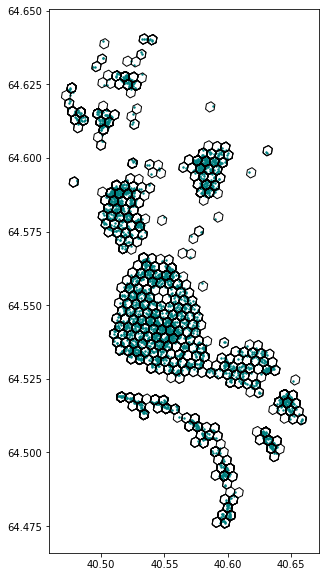

In [17]:
ax = get_center(geofacility).plot(
    figsize=(10,10), facecolor="teal", markersize=2)
get_center(geofacility3).plot(
    ax=ax, figsize=(10,10), facecolor="none", edgecolor="black")

## Готовим набор к экспорту

In [18]:
geofacility3.head(3)

,facility_id,type2,name,address,category,lat,lng,number_of_inhabitants,geometry
h3_09,,,,,,,,,
8911503346fffff,5137,Дом,Многоквартирный дом,NaN,NaN,64.455331,40.622060,33.0,"POLYGON ((40.61759 64.45587, 40.62060 64.45488..."
8911503346fffff,794,Дом,Многоквартирный дом,NaN,NaN,64.455491,40.622967,32.6,"POLYGON ((40.61759 64.45587, 40.62060 64.45488..."
891150330d3ffff,795,Дом,Многоквартирный дом,NaN,NaN,64.455494,40.623901,15.4,"POLYGON ((40.61995 64.45313, 40.62296 64.45214..."


In [19]:
geometry = geofacility3['geometry']
data = geofacility3[['facility_id', 'type2']]
gdf = gpd.GeoDataFrame(data=data, geometry=geometry, crs=geofacility3.crs)
gdf = gdf.reset_index()
gdf = gdf.drop(columns=['h3_09'])
gdf.head(3)

,facility_id,type2,geometry
0,5137,Дом,"POLYGON ((40.61759 64.45587, 40.62060 64.45488..."
1,794,Дом,"POLYGON ((40.61759 64.45587, 40.62060 64.45488..."
2,795,Дом,"POLYGON ((40.61995 64.45313, 40.62296 64.45214..."


In [20]:
gdf.shape

(5041, 3)

## Экспортируем набор данных с полигонами

In [21]:
gdf.to_file('data/facility_polygons.geojson', driver='GeoJSON')

## Экспортируем данные для DataLens

In [22]:
all_res = []

def convert(df):
    for _, row in df.iterrows():
        polygon = row.geometry
        x, y = polygon.exterior.xy
        pairs = zip(x, y)
        coords = []
        for pair in pairs:
            coords.append([pair[1], pair[0]])
        obj = {}
        obj['facility_id'] = row.facility_id
        obj['type2'] = row.type2
        obj['geometry'] = [coords]
        all_res.append(obj)

In [23]:
convert(gdf)

gdf_df = pd.DataFrame(all_res)
gdf_df.head(3)

,facility_id,type2,geometry
0,5137,Дом,"[[[64.45587444575847, 40.617592620485716], [64..."
1,794,Дом,"[[[64.45587444575847, 40.617592620485716], [64..."
2,795,Дом,"[[[64.45313033286712, 40.61995296608718], [64...."


In [24]:
gdf_df.to_csv('data/facility_polygons_lens.csv', index=False)

In [25]:
facility.head(3)

,facility_id,type2,name,address,category,lat,lng,number_of_inhabitants
0,5137,Дом,Многоквартирный дом,NaN,NaN,64.455331,40.622060,33.0
1,794,Дом,Многоквартирный дом,NaN,NaN,64.455491,40.622967,32.6
2,795,Дом,Многоквартирный дом,NaN,NaN,64.455494,40.623901,15.4


In [26]:
geometry = [[xy[1], xy[0]] for xy in zip(facility.lng, facility.lat)]

In [27]:
facility_dl = pd.DataFrame(facility[['facility_id', 'type2', 'name', 'address', 'category']])
facility_dl['geometry'] = geometry
facility_dl.head(3)

,facility_id,type2,name,address,category,geometry
0,5137,Дом,Многоквартирный дом,NaN,NaN,"[64.455331, 40.62206]"
1,794,Дом,Многоквартирный дом,NaN,NaN,"[64.455491, 40.622967]"
2,795,Дом,Многоквартирный дом,NaN,NaN,"[64.455494, 40.623901]"


In [28]:
facility_dl.to_csv('data/facility_lens.csv', quotechar='$', index=False)